In [2]:
import sys
!{sys.executable} -m pip install yfinance

  Using cached yfinance-0.2.43-py2.py3-none-any.whl.metadata (11 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached frozendict-2.4.4-py312-none-any.whl.metadata (23 kB)
  Using cached peewee-3.17.6-py3-none-any.whl
Using cached yfinance-0.2.43-py2.py3-none-any.whl (84 kB)
Using cached frozendict-2.4.4-py312-none-any.whl (16 kB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
tickers = ['XLY', 'XLP', 'XLE', 'XLK', 'XLV', 'XLF', 'XLI']
data = yf.download(tickers, start='2010-01-01', end='2023-01-01')['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

[*********************100%***********************]  7 of 7 completed


In [5]:
# Calculate mean return of all sectors each day
mean_returns = returns.mean(axis=1)

# Create labels: 1 if sector return > mean return, else 0
labels = returns.apply(lambda x: (x > mean_returns).astype(int))

In [6]:
# Create rolling average features (e.g., 5-day and 20-day moving averages)
rolling_features = pd.DataFrame()
for ticker in tickers:
    rolling_features[f'{ticker}_5d'] = returns[ticker].rolling(5).mean()
    rolling_features[f'{ticker}_20d'] = returns[ticker].rolling(20).mean()

# Drop NaN values
rolling_features = rolling_features.dropna()
labels = labels.loc[rolling_features.index]

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(rolling_features, labels, test_size=0.2, random_state=42)

In [8]:
# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

In [11]:
# Evaluate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the model: {accuracy:.2f}')

Accuracy of the model: 0.06


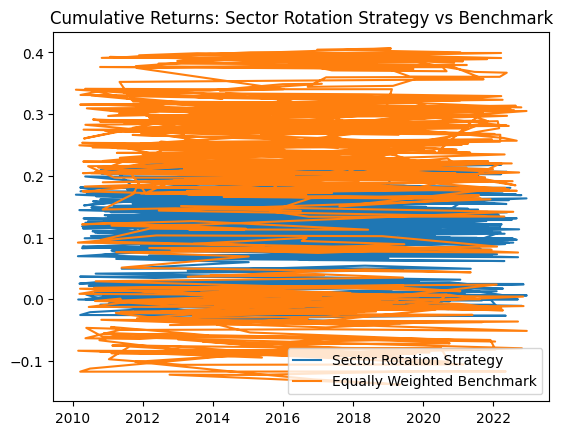

In [12]:
# Simulate sector rotation based on model predictions
investment_returns = pd.DataFrame(index=X_test.index)

# Iterate over each sector (ticker)
for ticker in tickers:
    # Multiply sector returns by the binary predictions (1 for outperform, 0 for underperform)
    investment_returns[ticker] = returns[ticker].loc[X_test.index] * y_pred[:, tickers.index(ticker)]

# Calculate cumulative returns of the sector rotation strategy
rotation_strategy = investment_returns.mean(axis=1).cumsum()

# Benchmark: Cumulative returns of equally weighted portfolio
benchmark = returns.mean(axis=1).loc[X_test.index].cumsum()

# Plot the results
plt.plot(rotation_strategy, label='Sector Rotation Strategy')
plt.plot(benchmark, label='Equally Weighted Benchmark')
plt.legend()
plt.title('Cumulative Returns: Sector Rotation Strategy vs Benchmark')
plt.show()